# Runtime Comparisons on Multi-Dimensional Isotropic Gaussian Data.

In [1]:
import algorithms
import linear_regression
from linear_regression import LinearRegression

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import copy
import scipy.linalg
import gurobipy as gp
from gurobipy import GRB
import sys
import itertools

## Set Random Seed.

In [2]:
np.random.seed(0)

## Data Generation (following section 5.1, MR23).

In [18]:
# Set dimensions.
total_observations = 5000
d = 50

# Generate X, a 3-dimensional isotropic Gaussian.
mean = np.zeros(d)
cov = np.identity(d)
x = np.random.multivariate_normal(mean, cov, total_observations)

# Generate Y, a linear combination of x with some noise.
sigma = 1
epsilon = np.random.normal(0, sigma, total_observations)
y = []
# take the inner product of x and beta and add the epsilon.
for i in range(total_observations):
    y.append(np.dot(x[i], np.ones(d)) + epsilon[i])
y = np.array(y)

## Plot Data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


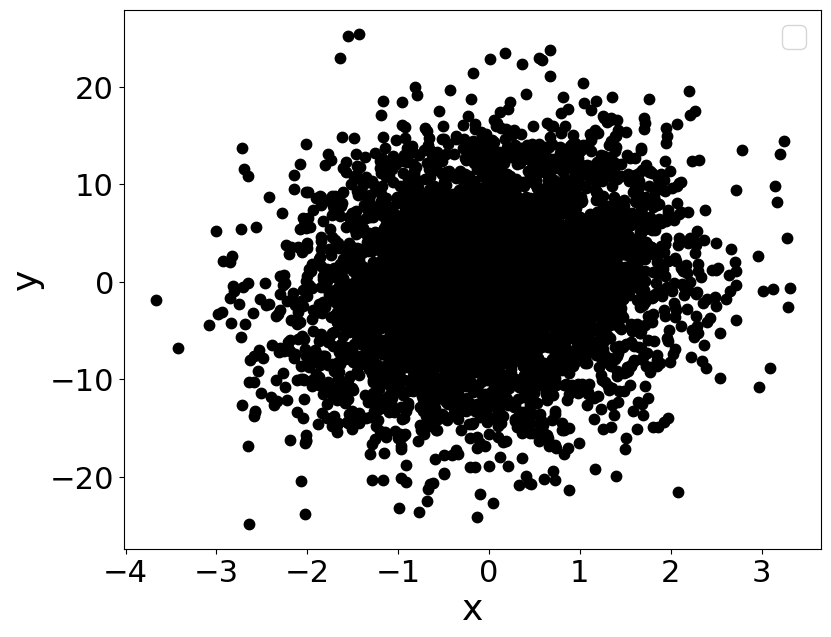

In [19]:
plt.figure(figsize=(9, 7))

plt.scatter(x[:, 1], y, marker='o', color='black', s=56)

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)
plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.show()

## Model Fitting

Fit the data using OLS regression.

In [20]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}\n"
)

Estimated beta1 with full dataset: 1.0171437882366763



## Net Approx. Algorithm
run the NetApprox Algorithm.

In [14]:
# the NetApprox algorithm. (https://github.com/df365/robustness_auditing/blob/main/code/MoitraRohatgi/algorithms.py)
# From Authors: Ankar Moitra and Dhruv Rohatgi.
# 

'''
For fixed lambda, compute maximum weight of any weight vector w
that has lambda in OLS(X,y,w)
'''
def solve_fixed_lambda(X,XR,lam):
    n = X.shape[0]
    d = X.shape[1]
    c = -np.ones((n))
    A_eq = np.zeros((d,n))
    b_eq = np.zeros((d))
    for i in range(d):
        A_eq[i] = (X.T)[i] * (XR@lam)
    m = gp.Model("net-model")
    m.Params.OutputFlag = 0
    w = m.addMVar(shape=n,vtype=GRB.CONTINUOUS,name="w",lb=0,ub=1)
    m.setObjective(c @ w, GRB.MINIMIZE)
    m.addConstr(A_eq @ w == b_eq)
    m.optimize()
    return w.X

'''
NET UPPER BOUND

Input:
- X: n x d (covariate matrix)
- y: n (response vector)
- trials: integer

Output:
- Net upper bound on Stability(X,y)
'''
def net_algorithm(X,y,trials):
    n = X.shape[0]
    d = X.shape[1]
    XR = np.zeros((d,n))
    for i in range(d-1):
        XR[i] = (X.T)[i+1]
    XR[d-1] = y
    XR = XR.T
    assert(np.linalg.matrix_rank(XR)==d)
    U,s,Vh = scipy.linalg.svd(XR, full_matrices=False)
    A = Vh.T @ np.diag(1.0/s) @ np.eye(d)
    wstar = np.zeros((n))
    for i in range(trials):
        v = np.random.multivariate_normal(np.zeros((d)),np.eye(d))
        v = v / np.linalg.norm(v)
        lam = A@v
        w = solve_fixed_lambda(X,XR,lam)
        if sum(w) > sum(wstar):
            wstar = w
    return n-sum(wstar), wstar

In [21]:
start_time = time.time()
n_sumwstar, wstar = net_algorithm(x,y,1000)
end_time = time.time()
print(f"N = {total_observations}, d = {d}, Stability = {n_sumwstar}, Time = {end_time - start_time}")
# Feb 12th: >10 min (for N=5000, d=200)
# Feb 12th: 3.42 min (for N=5000, d=50)

N = 5000, d = 50, Stability = 3885.5045820814644, Time = 222.56035995483398


In [38]:
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indice of wstar that are non-one.
mis_inds = np.where(wstar != 1)[0]

Number of points needed to be removed to zero-out the OLS solution: 446.69883783722213


## Recreating Figure 2 of MR23.

In [42]:
list_of_noise = [0.1, 0.5, 1, 2, 5, 10]
weights_removed = []
for noise_var in list_of_noise:
    # Generate Y, a linear combination of x with some noise.
    sigma = noise_var
    epsilon = np.random.normal(0, sigma, total_observations)
    y = []
    # take the inner product of x and beta and add the epsilon.
    for i in range(total_observations):
        y.append(np.dot(x[i], np.ones(d)) + epsilon[i])
    y = np.array(y)
    n_sumwstar, wstar = net_algorithm(x,y,10**3)
    weights_removed.append(n_sumwstar)

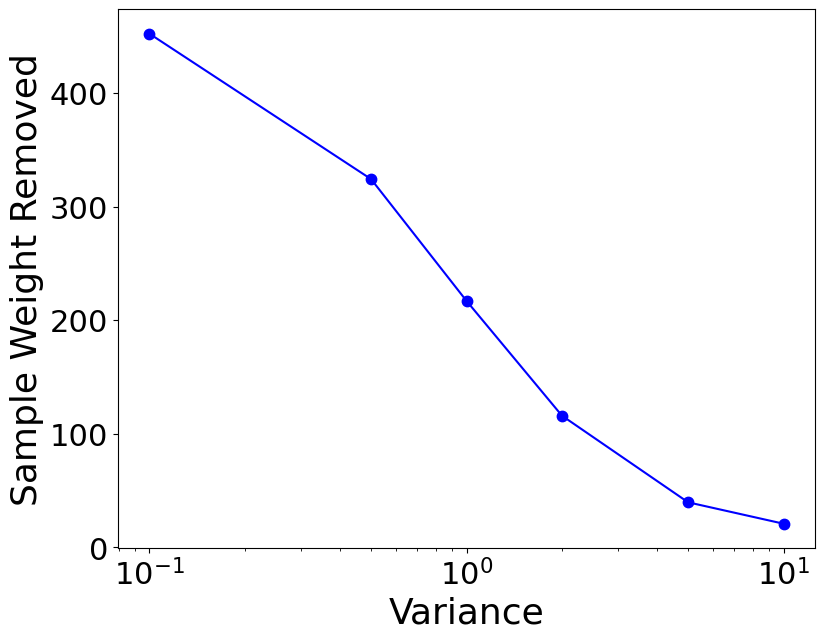

In [48]:
# create a scatter plot of the noise variance and the number of weights removed.
plt.figure(figsize=(9, 7))
plt.scatter(list_of_noise, weights_removed, marker='o', color='blue', s=56)
plt.plot(list_of_noise, weights_removed, color='blue')

plt.xscale('log')
plt.xlabel('Variance', fontsize=26)
plt.ylabel('Sample Weight Removed', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

## Test Runtime against Dimension.

In [258]:
# Record runtime.
NetApprox_times = []
# Set dimensions.
dimension_list = [2, 5, 10, 20, 50, 100, 200, 499]
total_observations = 500
for dim in dimension_list:
    d = dim
    # Generate X, a 3-dimensional isotropic Gaussian.
    mean = np.zeros(d)
    cov = np.identity(d)
    x = np.random.multivariate_normal(mean, cov, total_observations)

    # Generate Y, a linear combination of x with some noise.
    sigma = 1
    epsilon = np.random.normal(0, sigma, total_observations)
    y = []
    # take the inner product of x and beta and add the epsilon.
    for i in range(total_observations):
        y.append(np.dot(x[i], np.ones(d)) + epsilon[i])
    y = np.array(y)

    # start recording time.
    start_time = time.time()
    n_sumwstar, wstar = net_algorithm(x,y,1000)
    # end recording time.
    end_time = time.time()
    NetApprox_times.append(end_time - start_time)
    print("done dimension: ", d)


done dimension:  2
done dimension:  5
done dimension:  10
done dimension:  20
done dimension:  50
done dimension:  100
done dimension:  200
done dimension:  499


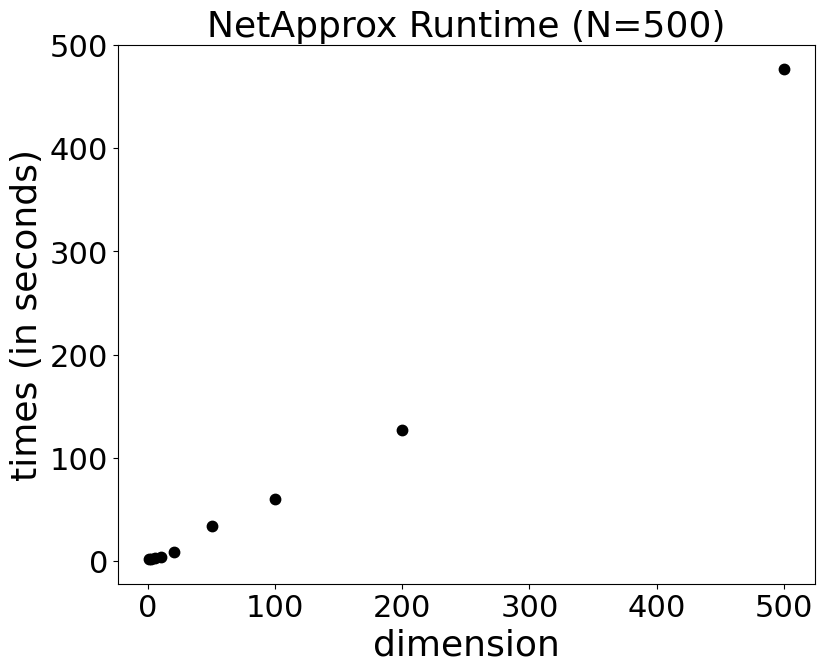

In [78]:
# create a scatter plot of dimension vs runtime.
plt.figure(figsize=(9, 7))
plt.scatter(dimension_list, NetApprox_times, marker='o', color='black', s=56)

plt.xlabel('dimension', fontsize=26)
plt.ylabel('times (in seconds)', fontsize=26)

plt.title('NetApprox Runtime (N=500)', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.savefig('NetApprox_runtimevdimension.pdf', bbox_inches='tight')
plt.show()

# Gurobi Implementation [FH23]

In [11]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)

set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1000 rows, 503 columns and 1000 nonzeros
Model fingerprint: 0x3a22b279
Model has 4 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-07, 1e+01]
  QLMatrix range   [2e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1000 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 1000 rows and 0 columns
Presolve time: 0.00s
Presolved: 6004 rows, 2004 columns, 20000 nonzeros
Presolved model has 1500 bilinear const

In [12]:
N = 500
gurobi_weights = np.array([w.X for w in weights_frac])
print(f'size of set to flip the sign: {N - sum(gurobi_weights)}')

size of set to flip the sign: 196.15479458018746


In [13]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=gurobi_weights, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 504 columns and 1 nonzeros
Model fingerprint: 0x57a6c7ef
Model has 4 quadratic constraints
Variable types: 4 continuous, 500 integer (500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-07, 1e+01]
  QLMatrix range   [2e-04, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

User MIP start produced solution with objective 303 (0.01s)
Loaded user MIP start with objective 303

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 4004 rows, 6504 columns, 20000 nonzeros
Presolved model has 4000 SOS constraint(s)
Variable types: 4004 contin

In [14]:
N = 500
inte_gurobi_weights = np.array([w.X for w in weights])
print(f'size of set to flip the sign: {N - sum(inte_gurobi_weights)}')

size of set to flip the sign: 197.0


## Timed Experiment for Integral Gurobi Algorithm [FH23]

In [ ]:
# Record runtime.
FH_times = []
FH_mis_size = []
# Set dimensions.
dimension_list = [2, 5, 10, 20, 50]

for elt in dimension_list:
    # Set dimensions.
    total_observations = 500
    d = elt

    # Generate X, a d-dimensional isotropic Gaussian.
    mean = np.zeros(d)
    cov = np.identity(d)
    x = np.random.multivariate_normal(mean, cov, total_observations)

    # Generate Y, a linear combination of x with some noise.
    sigma = 1
    epsilon = np.random.normal(0, sigma, total_observations)
    y = []
    # take the inner product of x and beta and add epsilon.
    for i in range(total_observations):
        y.append(np.dot(x[i], np.ones(d)) + epsilon[i])
    y = np.array(y)
    print(f'X shape is {x.shape}, y shape is {y.shape}.' )

    # start recording time.
    start_time = time.time()
    # Note: Directly running Gurobi on the integer-constrained instance, 
    # without a warm start obtained by rounding a fractional solution, 
    # often shows significantly worse performance (section 2.1 FH23).
    model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
    
    weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])
    model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
    # end recording time.
    end_time = time.time()
    print("done dimension: ", d)

    FH_times.append(end_time - start_time)
    N = 500
    gurobi_weights = np.array([w.X for w in weights])
    print(f'size of set to flip the sign: {N - sum(gurobi_weights)}')
    FH_mis_size.append(N - sum(gurobi_weights))


X shape is (500, 200), y shape is (500,).
set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.0.1 21A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1000 rows, 700 columns and 1000 nonzeros
Model fingerprint: 0x428126c3
Model has 201 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-10, 2e+01]
  QLMatrix range   [2e-05, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1000 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000


In [17]:
FH_mis_size

[200.0, 189.0, 194.0, 186.00000049191715, 156.0]

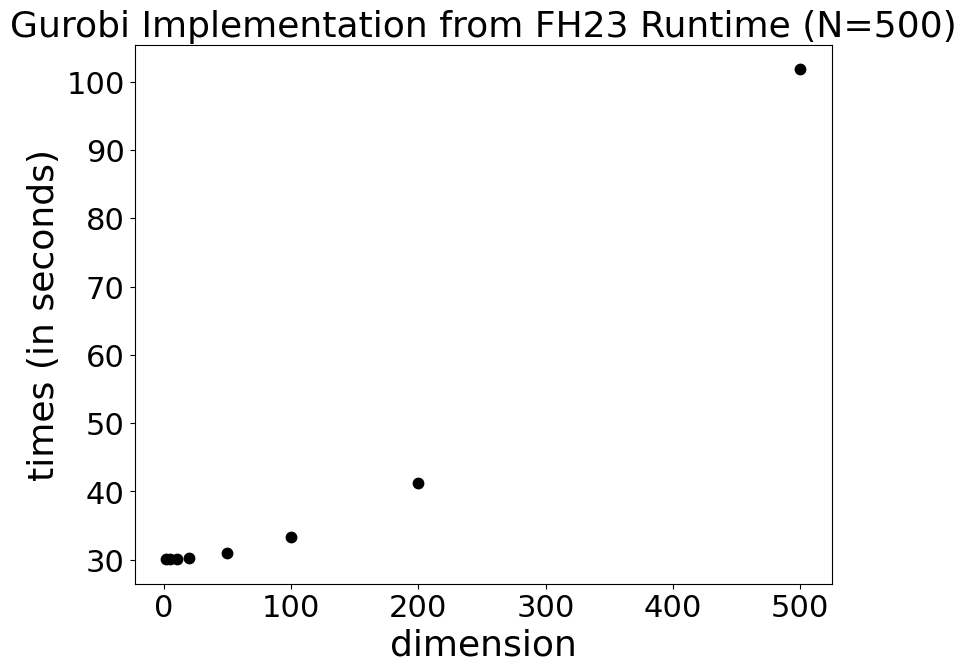

In [214]:
# create a scatter plot of dimension vs runtime.
plt.figure(figsize=(9, 7))
plt.scatter(dimension_list, FH_times, marker='o', color='black', s=56)

plt.xlabel('dimension', fontsize=26)
plt.ylabel('times (in seconds)', fontsize=26)

plt.title('Gurobi Implementation from FH23 Runtime (N=500)', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.savefig('Gurobi_runtimevdimension.pdf', bbox_inches='tight')
plt.show()

## Timed Experiment for Greedy-1Exact [KZC21]

In [236]:
# store the original x and y.
orig_x = x
orig_y = y
# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = linear_regression.create_orig_df(orig_x, orig_y, lr)
# store the original indices of x and y.
orig_inds_if = if_inds
orig_inds_newton = newton_inds

In [237]:
# sample run of the greedy algorithm.
dropped_order, exact_changes_beta, beta_estimates_greedy = linear_regression.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='1Exact')

print("dropped order: \n", dropped_order)
print("exact (greedy) beta estimates: \n", beta_estimates_greedy)

interation 0
index to remove 224
fitted beta1: 1.0176816924587433
interation 1
index to remove 150
fitted beta1: 1.0047097862054528
interation 2
index to remove 69
fitted beta1: 0.9951319360646436
interation 3
index to remove 94
fitted beta1: 0.9862078155716911
interation 4
index to remove 207
fitted beta1: 0.9772516059287564
interation 5
index to remove 10
fitted beta1: 0.968442665421411
interation 6
index to remove 355
fitted beta1: 0.9595843487684628
interation 7
index to remove 124
fitted beta1: 0.95077039640898
interation 8
index to remove 369
fitted beta1: 0.9432472408408334
interation 9
index to remove 5
fitted beta1: 0.9366890368143683
interation 10
index to remove 180
fitted beta1: 0.9300164247537768
interation 11
index to remove 113
fitted beta1: 0.92320253921003
interation 12
index to remove 216
fitted beta1: 0.9165737251035068
interation 13
index to remove 370
fitted beta1: 0.9105592788565495
interation 14
index to remove 312
fitted beta1: 0.9044967995888927
interation 15
i

In [247]:
# Record runtimes.
times = []
mis_size = []
# Set dimensions.
dimension_list = [2, 5, 10, 20, 50, 100, 200, 499]

for elt in dimension_list:
    # Set dimensions.
    total_observations = 500
    d = elt

    # Generate X, a d-dimensional isotropic Gaussian.
    mean = np.zeros(d)
    cov = np.identity(d)
    x = np.random.multivariate_normal(mean, cov, total_observations)

    # Generate Y, a linear combination of x with some noise.
    sigma = 1
    epsilon = np.random.normal(0, sigma, total_observations)
    y = []
    # take the inner product of x and beta and add epsilon.
    for i in range(total_observations):
        y.append(np.dot(x[i], np.ones(d)) + epsilon[i])
    y = np.array(y)
    print(f'X shape is {x.shape}, y shape is {y.shape}.' )

    # initialize greedy.
    # store the original x and y.
    orig_x = x
    orig_y = y
    # compute scores for initial round of the greedy algorithm.
    orig_df, if_inds, if_scores, newton_inds, newton_scores = linear_regression.create_orig_df(orig_x, orig_y, lr)
    # store the original indices of x and y.
    orig_inds_if = if_inds
    orig_inds_newton = newton_inds

    # start recording time.
    start_time = time.time()
    
    # run greedy
    dropped_order, exact_changes_beta, beta_estimates_greedy = linear_regression.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='1Exact')

    # end recording time.
    end_time = time.time()
    print("done dimension: ", d)

    times.append(end_time - start_time)

X shape is (500, 2), y shape is (500,).
done dimension:  2
X shape is (500, 5), y shape is (500,).
done dimension:  5
X shape is (500, 10), y shape is (500,).
done dimension:  10
X shape is (500, 20), y shape is (500,).
done dimension:  20
X shape is (500, 50), y shape is (500,).
done dimension:  50
X shape is (500, 100), y shape is (500,).
done dimension:  100
X shape is (500, 200), y shape is (500,).
done dimension:  200
X shape is (500, 499), y shape is (500,).
done dimension:  499


In [36]:
# results from runtime experiments.
dimension_list = [2, 5, 10, 20, 50, 100, 200, 499]

Gr1Exact_times = [0.12188267707824707,
 0.1284773349761963,
 0.13373303413391113,
 0.1837749481201172,
 1.0087270736694336,
 3.3516287803649902,
 6.207931995391846,
 34.30080318450928]

NetApprox_times = [1.8178341388702393,
 2.352041006088257,
 3.7632241249084473,
 8.640952110290527,
 32.8718900680542,
 59.21354913711548,
 129.2376630306244,
 468.5219531059265]

FH_times = [30.0765221118927,
 30.086939096450806,
 30.109911680221558,
 30.25550889968872,
 31.0050950050354,
 33.312812089920044,
 41.234622955322266,
 101.8116717338562] # no warm start.

FH_times2 = [60.09798502922058,
 60.15341401100159,
 60.23538613319397,
 60.55925893783569,
 61.87360119819641,
 73.54208421707153,
 132.85868906974792,
 None] # warm start.
# parameter settings d=[200, 500] started run at 11:13 - crashed at 12:01.


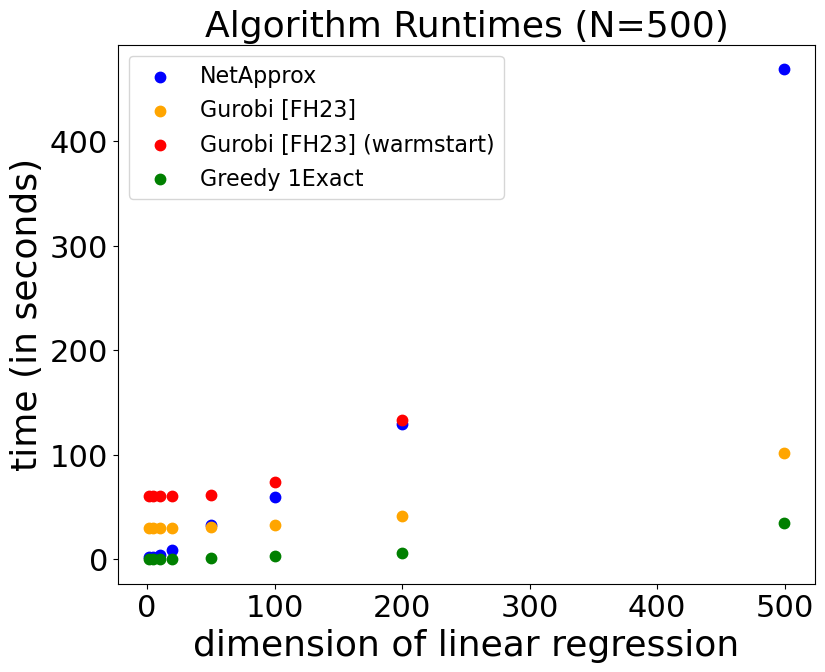

In [ ]:
# create a scatter plot of all three times against dimension.
plt.figure(figsize=(9, 7))
plt.scatter(dimension_list, NetApprox_times, marker='o', color='b', s=56, label='NetApprox')
plt.scatter(dimension_list, FH_times, marker='o', color='orange', s=56, label='Gurobi [FH23]')
plt.scatter(dimension_list, FH_times2, marker='o', color='red', s=56, label='Gurobi [FH23] (warmstart)')
plt.scatter(dimension_list, Gr1Exact_times, marker='o', color='green', s=56, label='Greedy 1Exact')

plt.xlabel('dimension of linear regression', fontsize=26)
plt.ylabel('time (in seconds)', fontsize=26)

plt.title('Algorithm Runtimes (N=500)', fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=16)

# plt.savefig('runtimes_vs_dimension.pdf', bbox_inches='tight')
plt.show()